<a href="https://colab.research.google.com/github/EunjinAn/M4_Ex/blob/main/M4_Exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Text Summarization**
- Our challenge of this project is text summarization task of nlp.

- this project was made based on the text summarization course of Hugging_Face(https://huggingface.co/course/chapter7/5?fw=pt)

- dataset: we used dataset,'beer_reviews_label_drift_neg' from HF with training(9,000), validation(1,260) and production(27,742)

In [ ]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate
!apt install git-lfs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [ ]:
# Installs
!pip install wandb -q
!pip install -U transformers huggingface_hub -qq
!pip install datasets -q
!pip install rouge_score
!pip install nltk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 KB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 5.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24955 sha256=624b5589f4211528fdf339bfd3ae365100e6ce79e34d2b8438846c3e773137b4
  Stored in directory: /root/.cache/pip/wheels/9b/3d/39/09558097d3119ca0a4d462df68f22c6f3c1b345ac63a09b86e
Successfully built rouge_score
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset, Dataset, DatasetDict
import torch
from torch import nn
from transformers import Trainer, AdamW, AutoModelForSequenceClassification, AutoTokenizer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
import datasets
import evaluate
from transformers import Seq2SeqTrainingArguments
from huggingface_hub import notebook_login
from transformers import Seq2SeqTrainer
from transformers import pipeline

from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler

from huggingface_hub import get_full_repo_name
from huggingface_hub import Repository
from tqdm.auto import tqdm
import torch

import nltk
from nltk.tokenize import sent_tokenize

import numpy as np
import pandas as pd

In [ ]:
# importing data from Hugging Face_beer_reviews_label_drift_neg(https://huggingface.co/datasets/arize-ai/beer_reviews_label_drift_neg)

dataset = load_dataset("arize-ai/beer_reviews_label_drift_neg")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating training split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating production split: 0 examples [00:00, ? examples/s]

Dataset beer_reviews_label_drift_neg downloaded and prepared to /root/.cache/huggingface/datasets/arize-ai___beer_reviews_label_drift_neg/default/1.0.0/19f47acda7a949b5528784d68d9f6aa4eaa144ba8ecaf7a234e4243e2ad1c4a0. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    training: Dataset({
        features: ['prediction_ts', 'beer_ABV', 'beer_name', 'beer_style', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'text', 'label'],
        num_rows: 9000
    })
    validation: Dataset({
        features: ['prediction_ts', 'beer_ABV', 'beer_name', 'beer_style', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'text', 'label'],
        num_rows: 1260
    })
    production: Dataset({
        features: ['prediction_ts', 'beer_ABV', 'beer_name', 'beer_style', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'text', 'label'],
        num_rows: 27742
    })
})

In [ ]:
# we selected train data(2000), validation(300) and test data(10), because of ram crash problem!
train_dataset = datasets.load_dataset('arize-ai/beer_reviews_label_drift_neg', split="training")
validation_dataset = datasets.load_dataset('arize-ai/beer_reviews_label_drift_neg', split="validation")
test_dataset = datasets.load_dataset('arize-ai/beer_reviews_label_drift_neg', split="production")

df_train = pd.DataFrame(train_dataset)
df_validation = pd.DataFrame(validation_dataset)
df_test = pd.DataFrame(test_dataset)

In [ ]:
# Let's look at the dataset!
df_train.head()

,prediction_ts,beer_ABV,beer_name,beer_style,review_appearance,review_palette,review_taste,review_aroma,text,label
0,1.658009e+09,8.0,Heady Topper,American Double / Imperial IPA,5.0,5.0,5.0,5.0,Thank you Lambicking for 12 cans of this. Trul...,2
1,1.658009e+09,9.5,Southampton Grand Cru,Belgian Strong Pale Ale,4.0,4.5,4.0,5.0,"Thanks to tai4ji2x for this. Pours a hazy, lig...",2
2,1.658009e+09,5.7,Blue Moon Harvest Moon Pumpkin Ale,Pumpkin Ale,4.0,4.0,3.0,3.5,Appearance: Ruddy amber with average carbonati...,1
3,1.658009e+09,9.2,Hopsickle Imperial India Pale Ale,American Double / Imperial IPA,4.5,4.0,4.0,3.5,Freshest bottle I could find. I'd try it again...,2
4,1.658009e+09,6.0,Santa's Private Reserve Ale,American Amber / Red Ale,4.5,5.0,4.5,5.0,Pours with amber brown hue with a huge ass lac...,2


To reducing the data training time, we used filter function, we get train data(460) and validation data(69). 

In [ ]:
dataset.set_format("pandas")
# Show counts for top 20 beer style
df_train["beer_style"].value_counts()[:20]

American IPA                        635
American Double / Imperial IPA      443
American Pale Ale (APA)             357
American Double / Imperial Stout    338
American Amber / Red Ale            320
Fruit / Vegetable Beer              304
American Porter                     275
Russian Imperial Stout              253
Belgian Strong Dark Ale             240
Witbier                             239
American Adjunct Lager              210
Tripel                              202
English Pale Ale                    173
American Barleywine                 159
Belgian Strong Pale Ale             152
American Pale Wheat Ale             142
Euro Pale Lager                     139
Märzen / Oktoberfest                138
Saison / Farmhouse Ale              135
American Brown Ale                  134
Name: beer_style, dtype: int64

In [ ]:
def filter_books(example):
    return (
        example["beer_style"] == "American IPA"
    )

In [ ]:
dataset.reset_format()

In [ ]:
beer_ctg = dataset.filter(filter_books)

Filter:   0%|          | 0/9000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1260 [00:00<?, ? examples/s]

Filter:   0%|          | 0/27742 [00:00<?, ? examples/s]

In [ ]:
beer_ctg = beer_ctg.filter(lambda x: len(x["beer_name"].split()) > 2)

Filter:   0%|          | 0/635 [00:00<?, ? examples/s]

Filter:   0%|          | 0/97 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2037 [00:00<?, ? examples/s]

In [ ]:
# Training a summarization model on all reviews would take far too long on a single GPU,
# so we used generating summaries for a single domain of products with "American IPA"
beer_ctg

DatasetDict({
    training: Dataset({
        features: ['prediction_ts', 'beer_ABV', 'beer_name', 'beer_style', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'text', 'label'],
        num_rows: 460
    })
    validation: Dataset({
        features: ['prediction_ts', 'beer_ABV', 'beer_name', 'beer_style', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'text', 'label'],
        num_rows: 69
    })
    production: Dataset({
        features: ['prediction_ts', 'beer_ABV', 'beer_name', 'beer_style', 'review_appearance', 'review_palette', 'review_taste', 'review_aroma', 'text', 'label'],
        num_rows: 1517
    })
})

In here, we did to tokenize and encode our reviews and their titles. As usual, we begin by loading the tokenizer associated with the pretrained model checkpoint. We used mt5-small as our checkpoint.

In [ ]:
from transformers import AutoTokenizer

model_checkpoint = "google/mt5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.9/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# data preprocessing

max_input_length = 512
max_target_length = 30


def preprocess_function(examples):
    model_inputs = tokenizer(
        examples["text"],
        max_length=max_input_length,
        truncation=True,
    )
    labels = tokenizer(
        examples["beer_name"], max_length=max_target_length, truncation=True
    )
    model_inputs['labels'] = labels['input_ids']
    return model_inputs

In [ ]:
# tokenized
tokenized_datasets = beer_ctg.map(preprocess_function, batched=True)

Map:   0%|          | 0/460 [00:00<?, ? examples/s]

Map:   0%|          | 0/69 [00:00<?, ? examples/s]

Map:   0%|          | 0/1517 [00:00<?, ? examples/s]

In [ ]:
# tokenized, we do not need, after remov this cell. 
tokenized_datasets_train = train_dataset.map(preprocess_function, batched=True)
tokenized_datasets_validaton = validation_dataset.map(preprocess_function, batched=True)
tokenized_datasets_test = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1260 [00:00<?, ? examples/s]

Map:   0%|          | 0/27742 [00:00<?, ? examples/s]

### **Matric for text summarization**

**ROUGE** score: Most commonly used metrics for summarization model.
- ROUGE is based on computing the precision and recall scores for the overlap.

- Recall= 
Totalnumberofwordsinreferencesummary/
Numberofoverlappingwords
​

- Precision= 
Totalnumberofwordsingeneratedsummary/
Numberofoverlappingwords
​




In [ ]:
# from rouge_score import rouge_scorer

#scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
#scores = scorer.score('The quick brown fox jumps over the lazy dog','The quick brown dog jumps on the log.')

In [ ]:
rouge_score = evaluate.load("rouge")

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def three_sentence_summary(text):
    return "\n".join(sent_tokenize(text)[:3])

print(three_sentence_summary(beer_ctg["training"][0]["text"]))

Heavy nose.
Pine and citrus.
Pours a nice amber color.


In [ ]:
def evaluate_baseline(dataset, metric):
    summaries = [three_sentence_summary(text) for text in dataset["text"]]
    return metric.compute(predictions=summaries, references=dataset["beer_name"])

### What is rouge1, 2, L, Lsum?

 rouge2 measures the overlap between bigrams (think the overlap of pairs of words), while rougeL and rougeLsum measure the longest matching sequences of words by looking for the longest common substrings in the generated and reference summaries. The “sum” in rougeLsum refers to the fact that this metric is computed over a whole summary, while rougeL is computed as the average over individual sentences.


In [ ]:
score = evaluate_baseline(beer_ctg["validation"], rouge_score)
rouge_names = ["rouge1", "rouge2", "rougeL", "rougeLsum"]
rouge_dict = dict((rn, round(score[rn] * 100, 2)) for rn in rouge_names)
rouge_dict

{'rouge1': 2.91, 'rouge2': 0.93, 'rougeL': 2.84, 'rougeLsum': 2.9}

In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from transformers import Seq2SeqTrainingArguments

batch_size = 4
num_train_epochs = 8
# Show the training loss with every epoch
logging_steps = len(tokenized_datasets["training"]) // batch_size
model_name = model_checkpoint.split("/")[-1]


args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-beer-ctg-en",
    evaluation_strategy="epoch",
    learning_rate=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=num_train_epochs,
    predict_with_generate=True,
    logging_steps=logging_steps,
    push_to_hub=True,
)

/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_score.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(
    beer_ctg["training"].column_names)

In [ ]:
features = [tokenized_datasets["training"][i] for i in range(2)]
data_collator(features)

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'input_ids': tensor([[   259,  55905, 108239,    260,  33902,    305, 156754,    260,   5517,
            263,    259,    262,  11555,    259, 124994,   6775,    260,   2155,
           8277,    261,    305,    259,    262,    259, 177186,    259,  10617,
            304,    283,  27159,  65801,    261,    259,    263, 102156,    304,
         126349,    305,  43345,    263,   1150,  19338,    260,    259,  37627,
           2155,  95716,    265, 109699,    260,  80204,   8271,   4368,    261,
           4875,    259,    262,  11555,   4649,    344,    287,   3162,    260,
            653,   2784, 163436,  65901,    265,    259,  58793,    260,   1494,
            339,    776,    259,    262,    259,    270,  83112,  43345,    259,
            264, 139077,   6369,    259,  49394,    261,   1156,    269,  67171,
         147106,  16322,    295,    287,    287,    259, 158972,   7060,    260,
            259, 103236,    347,    261,  20561,   1059,  35332,    259,  49394,
            27

In [ ]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["training"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Cloning https://huggingface.co/EJaalborg2022/mt5-small-finetuned-beer-ctg-en into local empty directory.


I tried several batch size with 4, 8, 10, 20 etc.

but over 5 of batch size crashed Ram even GPU.
so we used batch size 4, and it take about 5 hours for training.


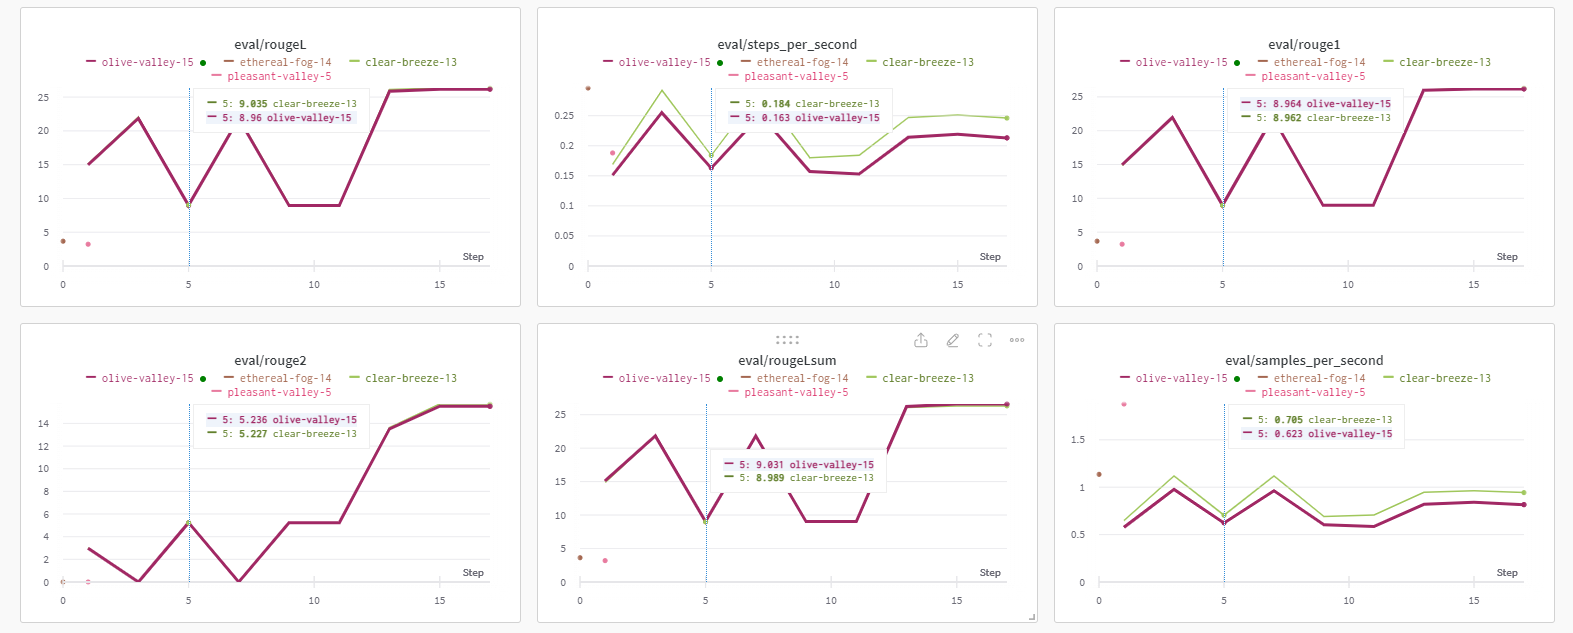


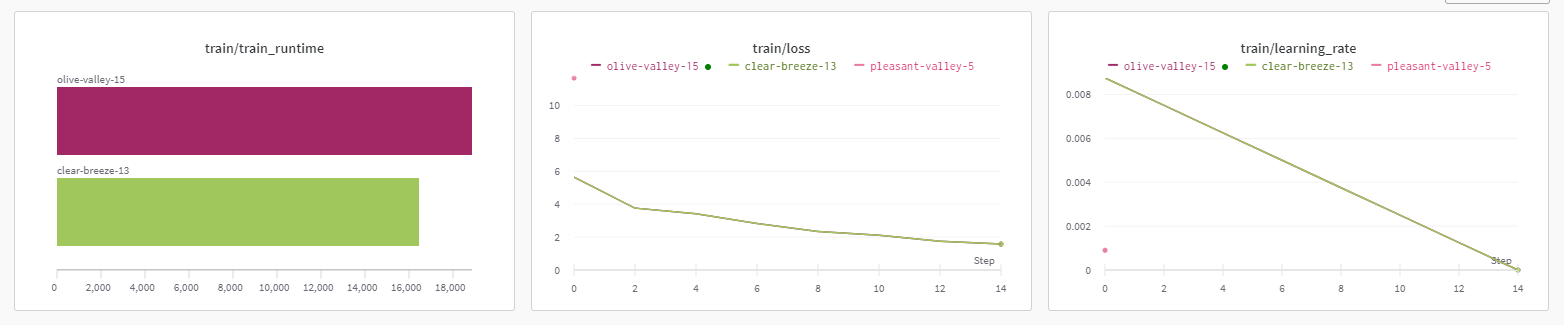

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 460
  Num Epochs = 8
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 920
  Number of trainable parameters = 300176768
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,5.648400,3.705072,14.961700,2.971900,14.990100,15.104000
2,3.762200,3.216770,21.980700,0.000000,21.835700,21.827700
3,3.423700,2.876746,8.964200,5.235800,8.959700,9.030700
4,2.820400,2.483600,21.980700,0.000000,21.835700,21.827700
5,2.333500,2.233964,8.964200,5.235800,8.959700,9.030700
6,2.111800,1.912053,8.964200,5.235800,8.959700,9.030700
7,1.753300,1.657053,25.975200,13.516100,25.860900,26.215300
8,1.575500,1.556210,26.172700,15.517600,26.181300,26.594300


***** Running Evaluation *****
  Num examples = 69
  Batch size = 4
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_toke

TrainOutput(global_step=920, training_loss=2.92857841823412, metrics={'train_runtime': 18883.4462, 'train_samples_per_second': 0.195, 'train_steps_per_second': 0.049, 'total_flos': 1120354501263360.0, 'train_loss': 2.92857841823412, 'epoch': 8.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 69
  Batch size = 4
Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}



Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_version": "4.26.1"
}

Generate config GenerationConfig {
  "decoder_start_token_id": 0,
  "eos_token_id": 1,
  "pad_token_id": 0,
  "transformers_

{'eval_loss': 1.5562102794647217,
 'eval_rouge1': 26.1727,
 'eval_rouge2': 15.5176,
 'eval_rougeL': 26.1813,
 'eval_rougeLsum': 26.5943,
 'eval_runtime': 84.6101,
 'eval_samples_per_second': 0.816,
 'eval_steps_per_second': 0.213,
 'epoch': 8.0}

In [ ]:
trainer.push_to_hub(commit_message="Training complete", tags="summarization")


Saving model checkpoint to mt5-small-finetuned-beer-ctg-en
Configuration saved in mt5-small-finetuned-beer-ctg-en/config.json
Configuration saved in mt5-small-finetuned-beer-ctg-en/generation_config.json
Model weights saved in mt5-small-finetuned-beer-ctg-en/pytorch_model.bin
tokenizer config file saved in mt5-small-finetuned-beer-ctg-en/tokenizer_config.json
Special tokens file saved in mt5-small-finetuned-beer-ctg-en/special_tokens_map.json
Copy vocab file to mt5-small-finetuned-beer-ctg-en/spiece.model


Upload file pytorch_model.bin:   0%|          | 32.0k/1.12G [00:00<?, ?B/s]

Upload file runs/Mar11_08-50-17_2267b12ddf8d/events.out.tfevents.1678524719.2267b12ddf8d.227.0: 100%|#########…

Upload file runs/Mar11_08-50-17_2267b12ddf8d/events.out.tfevents.1678543768.2267b12ddf8d.227.2: 100%|#########…

remote: Scanning LFS files of refs/heads/main for validity...        
remote: LFS file scan complete.        
To https://huggingface.co/EJaalborg2022/mt5-small-finetuned-beer-ctg-en
   ab66c55..626d170  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/EJaalborg2022/mt5-small-finetuned-beer-ctg-en
   ab66c55..626d170  main -> main

To https://huggingface.co/EJaalborg2022/mt5-small-finetuned-beer-ctg-en
   626d170..7ab3dad  main -> main

   626d170..7ab3dad  main -> main



'https://huggingface.co/EJaalborg2022/mt5-small-finetuned-beer-ctg-en/commit/626d1703f64d998b0e85e4cc59abcc41fc2efb20'

In [ ]:
# EJaalborg2022/mt5-small-finetuned-beer-ctg-en
trainer.push_to_hub('mt5-small-finetuned-beer-ctg-en')
model.push_to_hub('mt5-small-finetuned-beer-ctg-en')
dataset.push_to_hub('mt5-small-finetuned-beer-ctg-en')

Saving model checkpoint to mt5-small-finetuned-beer-ctg-en
Configuration saved in mt5-small-finetuned-beer-ctg-en/config.json
Configuration saved in mt5-small-finetuned-beer-ctg-en/generation_config.json
Model weights saved in mt5-small-finetuned-beer-ctg-en/pytorch_model.bin
tokenizer config file saved in mt5-small-finetuned-beer-ctg-en/tokenizer_config.json
Special tokens file saved in mt5-small-finetuned-beer-ctg-en/special_tokens_map.json
Copy vocab file to mt5-small-finetuned-beer-ctg-en/spiece.model
To https://huggingface.co/EJaalborg2022/mt5-small-finetuned-beer-ctg-en
   7ab3dad..68145b9  main -> main

   7ab3dad..68145b9  main -> main

Configuration saved in mt5-small-finetuned-beer-ctg-en/config.json
Configuration saved in mt5-small-finetuned-beer-ctg-en/generation_config.json
Model weights saved in mt5-small-finetuned-beer-ctg-en/pytorch_model.bin
Uploading the following files to EJaalborg2022/mt5-small-finetuned-beer-ctg-en: config.json,pytorch_model.bin,generation_config.j

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/28 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

**mt5-Model** is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo with `use_auth_token` or log in with `huggingface-cli login` and pass `use_auth_token=True`.



In [ ]:
df_test['text'][10]

'(Served in a weizen glass) mind estems haltbar bis:201010 A- This brew pours a pale golden color with a slight hazy 1st pour and a much denser 2nd pour. There is a sea of boiling microbubbles that support a thick creamy off-white head that laces with each sip. S- The rich yeasty aroma with a full banana is followed by a hop note and then a clove note comes through and grows as the beer opens up. T- A mellow white bread dough and yeasty flavor has a soft clove spice quality and a soft dry pils malt note in the background. The finish is a slight tartness with a slight carbonic acid note in that cleans up the finish. A soft green hop note grows into a nice hop snap as it warms. M- The medium-light mouthfeel has an effervescent carbonation in the finish. D- This beer has a nice green flavor that is a bit dry and a bit softer than the aroma and less complex, but very drinkable none the less.'

### TEXT SUMMARIZATION using Gradio and Streamlit

Unfortunately, the mt5-Model I chose did not make a pipeline for the following reasons.

error message:
 - mt5-Model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models' If this is a private repository, make sure to pass a token having permission to this repo with use_auth_token or log in with huggingface-cli login and pass use_auth_token=True.